# XGBoost Model

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import xgboost as xgb
from sklearn.metrics import mean_squared_error

#### Read Data

In [79]:
observed = pd.read_parquet('data/data/A/X_train_estimated.parquet', engine="fastparquet")
observed = observed.set_index("date_forecast")

target = pd.read_parquet('data/data/A/train_targets.parquet', engine="fastparquet")
target = target.set_index("time")

def split_time_index(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

observed = split_time_index(observed)
# observed = observed.resample('60T').mean()

X_train = observed.loc[observed.index < '01-01-2022']
X_test = observed.loc[(observed.index < '01-01-2023') & (observed.index >= '01-01-2022')]
# X_test = X_test.loc[observed.index >= '01-01-2021']

Y_train = target.loc[target.index < '01-01-2022']
Y_test = target.loc[(target.index < '01-01-2023') & (target.index >= '01-01-2022')]  
# Y_test = Y_test.loc[target.index >= '01-01-2021']
observed.head()

,date_calc,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,day,quarter,month,year
date_forecast,,,,,,,,,,,,,,,,,,,,,
2022-10-28 22:00:00,2022-10-27 07:00:18,8.4,1.233,1425.099976,0.0,0.0,1211.699951,1.0,281.399994,0.0,...,29429.699219,0.8,-0.4,0.7,-0.0,22,28,4,10,2022
2022-10-28 22:15:00,2022-10-27 07:00:18,8.4,1.233,2085.899902,0.0,0.0,1560.500000,1.0,281.299988,0.0,...,23604.099609,0.7,-0.4,0.7,-0.0,22,28,4,10,2022
2022-10-28 22:30:00,2022-10-27 07:00:18,8.3,1.233,2746.600098,0.0,0.0,1909.400024,1.0,281.200012,0.0,...,17799.800781,0.7,-0.3,0.6,-0.0,22,28,4,10,2022
2022-10-28 22:45:00,2022-10-27 07:00:18,8.3,1.233,3407.399902,0.0,0.0,2258.199951,1.0,281.200012,0.0,...,12016.500000,0.6,-0.2,0.6,-0.0,22,28,4,10,2022
2022-10-28 23:00:00,2022-10-27 07:00:18,8.2,1.233,4068.199951,0.0,0.0,2607.000000,1.0,281.100006,0.0,...,6254.399902,0.6,-0.1,0.6,-0.0,23,28,4,10,2022


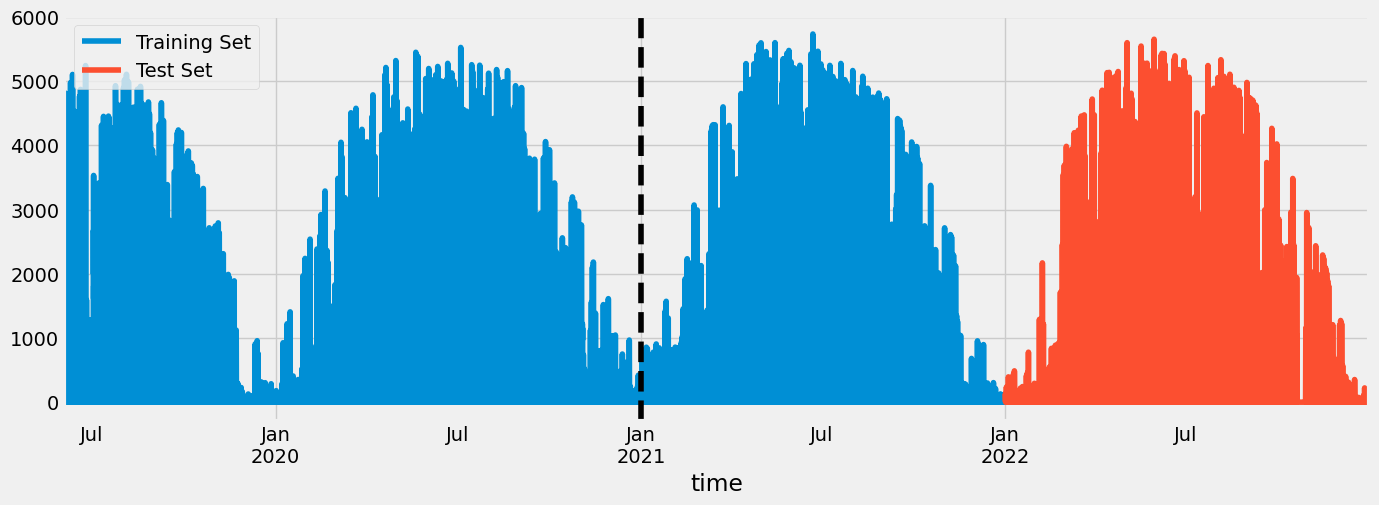

In [73]:
fig, ax = plt.subplots(figsize=(15,5))
Y_train.plot(ax=ax, label='Training set')
Y_test.plot(ax=ax, label='Test set')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Select features

In [74]:
FEATURES = ['clear_sky_energy_1h:J',
            'dew_or_rime:idx',
            'diffuse_rad:W',
            'direct_rad:W',
            'is_day:idx',
            'precip_5min:mm',
            'precip_type_5min:idx',
            'prob_rime:p',
            'relative_humidity_1000hPa:p',
            'snow_density:kgm3',
            'snow_water:kgm2',
            'sun_elevation:d',
            'super_cooled_liquid_water:kgm2',
            't_1000hPa:K',
            'month',
            'day',
            'hour']
TARGET = 'pv_measurement'

In [75]:
x_train = X_train[FEATURES]
x_test = X_test[FEATURES]

y_train = Y_train[TARGET]
y_test = Y_test[TARGET]

### Model

In [76]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

C:\Users\marga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\marga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\marga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_

XGBoostError: [20:38:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\data\data.cc:501: Check failed: this->labels.Size() % this->num_row_ == 0 (881 vs. 0) : Incorrect size for labels.

### Feature Importance

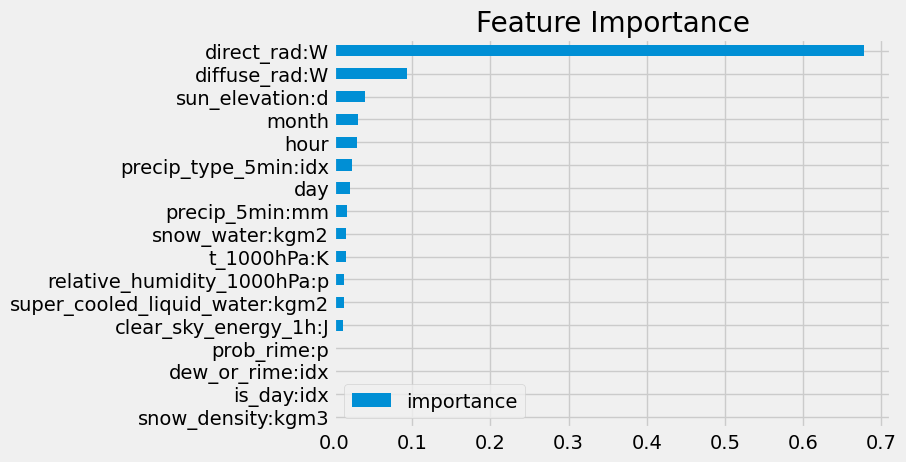

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Prediction

C:\Users\marga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\marga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\marga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_

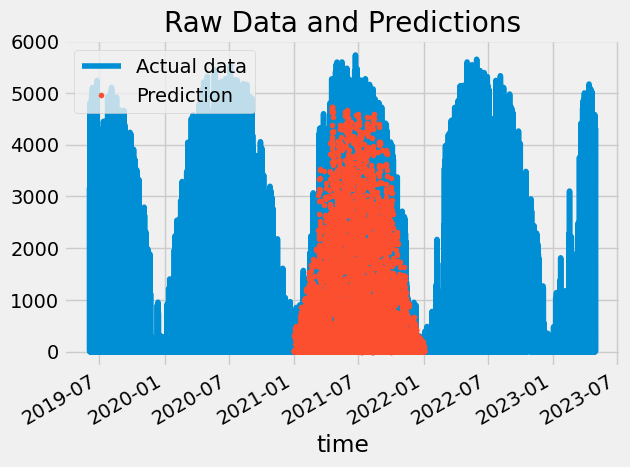

In [ ]:
Y_test['prediction'] = reg.predict(x_test)
target = target.merge(Y_test[['prediction']], how='left', left_index=True, right_index=True, suffixes=('_target', '_test'))
target.head()
ax = target['pv_measurement'].plot()
target['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual data', 'Prediction'])
ax.set_title('Raw Data and Predictions')
plt.show()

# Y_test.head()